### Testing Jupyter Notebook for visualizations using Matplotlib for displaying COVID-19 data using map\n",
This code is adapted and modified from [this tutorial](https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac)
    

In [89]:
# import libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [90]:
# initialize visualization set
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

In [91]:
# get relative path to shape file
# path = "C:/Users/mwcchan/Local Documents/malaysia-covid/maps/districts/polbnda_mys.shp"
# rel_path = os.path.relpath(path)
rel_path = '..\\maps\\districts\\polbnda_mys.shp'

In [92]:
# get shapefile
sf = shp.Reader(rel_path)

In [93]:
district_records = pd.DataFrame(sf.records(), columns=["fa", "country", "state", "district", "misc1", "misc2", "misc3", "misc4", "misc5"])
# district_records[district_records['state'] == 'SABAH'].groupby(['district'], as_index=False).count()

Note: the map of the districts from the shapefile used does not exactly line up with the districts from the COVID-19 cases source (covid19.place). However, some of the districts in the shapefile are classified as areas in the website (e.g. Marudi in Sarawak)

We probably need to take the "area data" for Sabah and Sarawak instead of grouping by district

In [94]:
# get connection to mysql database

import mysql.connector as msc
import json

# open json file of local_db_config
local_db_config = json.load(open('local_db_config.json'))

# make connection to the database
connection = msc.connect(
    host=local_db_config['host'], 
    port=local_db_config['port'],
    user=local_db_config['user'],
    password=local_db_config['password'],
    auth_plugin='mysql_native_password',
    database=local_db_config['database']
)

cursor = connection.cursor()

## Edge Cases
When fetching data from the database, we have to consider the following edge cases, or rather, discrepancies between the shape file and the website used to obtain the district case data:

### In general
The "regions" in the shapefile correspond with the *districts* on the website, so we have to **group by district name**.

### Sabah, Sarawak, Pahang, Perlis
The "regions" in the shapefile correspond with the *areas* on the website, so we have to **replace the 'area name' for the district name** instead.

### Kuala Lumpur
In the shapefile, Kuala Lumpur is only listed as *only one district*, so we have to group that together by itself.

### Labuan
In the shapefile, 
- Labuan is listed as "WILAYAH PERSEKUTUAN LABUAN".

### Selangor
In the shapefile,
- "Hulu Langat" is misspelt as "Ulu Langat"

### Penang
In the shapefile,
- "Timur Laut" is misspelt as "Timor Laut"

### Sabah
In the shapefile, 
- "Tongod" is misspelt as "Tongot"
- "Kota Belud" is misspelt at "Kota Belut"
- "Pensingan" should be referred to as "Nabawan"
- "Labuk & Sugut" are split into two districts: "Beluran" and "Telupid" 
- "Kuala Penyu" is referred to as "Pedalaman"
([Source](https://www.sabahoutbreak.com/))

### Sarawak
In the shapefile,
- "Meradong" is misspelt as "Maradong" and is listed as a separate district, even though the COVID-19 website lists it as an area

### Johor
In the shapefile,
- "Tangkak" is referred to as "Ledang"
- "Kulai" is referred to as "Kulai Jaya"

### Perak
In the shapefile,
- "Larut Matang Selama" is referred to both as "Larut & Matang"
- "Selama" is an area under "Larut Matang Selama", but classified as a district in the shapefile

### Perlis
In the shapefile,
- "Titi Tinggi" is referred to as "Kangar" (geographically)

### Pahang
In the shapefile,
- "Cameron Highland" is listed as a district in the shapefile, but it is in the COVID-19 data website under Pahang > Daerah > Cameron Highlands

In [95]:
# get covid data sql query
sql = """

    # Generic
    SELECT 
        area.district_name, 
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases 
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND state_name != 'sabah' AND state_name != 'sarawak' AND state_name != 'kualalumpur' AND state_name != 'pahang'
    AND state_name != 'selangor' AND state_name != 'johor' AND state_name != 'perak' AND state_name != 'labuan' AND state_name != 'perlis' AND state_name != 'penang'
    GROUP BY area.district_name

    UNION

    # Sabah
    SELECT
        CASE
            WHEN area.area_name = 'Tongod' THEN 'Tongot'
            WHEN area.area_name = 'Nabawan' THEN 'Pensingan'
            WHEN area.area_name = 'Kota Belud' THEN 'Kota Belut'
            WHEN area.area_name = 'Beluran' OR area.area_name = 'Telupid' THEN 'Labuk & Sugut'
            WHEN area.area_name = 'Kuala Penyu' THEN 'Pedalaman'
            ELSE area.area_name
        END AS district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'sabah')
    GROUP BY area.area_name, area.district_name

    UNION

    # Labuan
    SELECT
        CASE
            WHEN area.area_name = 'Labuan' THEN 'WILAYAH PERSEKUTUAN LABUAN'
            ELSE area.area_name
        END AS district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'labuan')
    GROUP BY area.area_name, area.district_name

    UNION

    # Johor
    SELECT
        CASE
            WHEN area.district_name = 'Tangkak' THEN 'Ledang'
            WHEN area.district_name = 'Kulai' THEN 'Kulai Jaya'
            ELSE area.district_name
        END AS district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'johor')
    GROUP BY area.district_name

    UNION

    # Penang
    SELECT
        CASE
            WHEN area.district_name = 'Timur Laut' THEN 'Timor Laut'
            ELSE area.district_name
        END AS district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'ppinang')
    GROUP BY area.district_name

    UNION

    # Perak
    SELECT
        CASE
            WHEN area.district_name = 'Larut Matang Selama' THEN 'Larut & Matang'
            ELSE area.district_name
        END AS district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'perak')
    GROUP BY area.district_name

    UNION

    # Perak (Selama)
    SELECT
        area.area_name district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND state_name = 'perak' AND area.area_name='Selama'
    GROUP BY area.district_name 

    UNION

    # Perlis
    SELECT
        CASE
            WHEN area.area_name = 'Titi Tinggi' THEN 'Kangar'
            ELSE area.area_name
        END AS district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'perlis')
    GROUP BY area.area_name, area.district_name

    UNION

    # Sarawak
    SELECT
        area.area_name district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'sarawak')
    GROUP BY area.area_name, area.district_name

    UNION

    # Sarawak (Meradong)
    SELECT
        'Maradong' district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'sarawak') AND (area.area_name = 'Meradong')

    UNION

    # Pahang
    SELECT
        area.area_name district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'pahang')
    GROUP BY area.area_name, area.district_name

    UNION

    # Pahang (Cameron Highlands)
    SELECT
        'Cameron Highland' district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'pahang' AND area_name = 'Cameron Highlands')
    GROUP BY area.area_name, area.district_name

    UNION

    # Kuala Lumpur
    SELECT 
        'Kuala Lumpur' district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND (state_name = 'kualalumpur')

    UNION

    # Selangor
    SELECT 
        CASE
            WHEN area.district_name = 'Hulu Langat' THEN 'Ulu Langat'
            ELSE area.district_name
        END AS district_name,
        districts.state_name state_name,
        SUM(area.new_cases) new_cases, 
        SUM(area.fourteen_days_cases) fourteen_days_cases, 
        SUM(area.active_cases) active_cases, 
        SUM(area.total_cases) total_cases 
    FROM malaysia_area_covid_cases area
    JOIN districts ON area.district_name = districts.district_name
    WHERE date=DATE(DATE_SUB(CURDATE(), INTERVAL 21 HOUR)) AND state_name = 'selangor'
    GROUP BY area.district_name

"""

cursor.execute(sql)

In [96]:
# parse covid data into dataframe
covid_data = pd.DataFrame(cursor.fetchall(), columns=["district", "state", "new", "fourteen", "active", "total"])

In [97]:
# import hls_to_rgb helper function (for color conversion)
from colorsys import hsv_to_rgb

In [98]:
# converts color with h, l and s values to rgb string
def convertColor(h, s, v):
    color = hsv_to_rgb(h, float(s), v)
    return "#{}{}{}".format(
        np.base_repr(int(color[0] * 256), base=16).zfill(2), 
        np.base_repr(int(color[1] * 256), base=16).zfill(2), 
        np.base_repr(int(color[2] * 256), base=16).zfill(2)
    )

In [99]:
import math
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import mplcursors

In [154]:
def plot_map_fill(sf, x_lim = None, 
                          y_lim = None, 
                          figsize = (25,9)):

    # initialize result list for districts with "NA"
    rs = []
    # initialize result list for active cases for the districts used in generating the shapefile
    # used to generate the key for the plot
    usedData = []
   
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    for id in range(len(sf.shapeRecords())):
        shape = sf.shapeRecords()[id]
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]

        ax.plot(x, y, 'k')
        # set title of plot
        ax.set_title('Number of COVID-19 cases in Malaysia by district', fontsize=36)

        # check whether the district has case data
        district_data = district_records.iloc(0)[id]
        result = covid_data[covid_data['district'].str.upper() == district_data['district']]
        txt = None
        if result.empty:
            txt = "NA"
        else:
            txt = result['new'].iloc(0)[0]

        # put text of id in region (for debugging purposes)
        if (x_lim == None) and (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            # plt.text(x0, y0, txt, fontsize='small', fontweight='700')

        shape_ex = sf.shape(id)

        # fill shape with color
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]

        if txt == "NA" or txt == None:
            rs += [id]
            ax.fill(x_lon,y_lat, '#aaaaaa') # grey for no data
        else:
            # shades of red, with darker = more cases
            # print(txt, convertColor(0, (8 - math.log(txt+2)) / 8, 0.5))
            usedData += [txt]
            # print(txt, convertColor(0, (8 - math.log(txt+2)) / 8, 1))
            ax.fill(x_lon,y_lat, convertColor(0.001, (math.log(txt+2)) / 8, 0.999))
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

    # make plot interactive
    plt.ion()

    # put legend (colorbar) for plot
    colors = [mcolors.hsv_to_rgb([0, l, 1]) for l in np.linspace(0, 1, len(sf.records()))] 
    cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
    norm = mcolors.LogNorm(vmin=1, vmax=max(usedData))
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # get ticks
    ticks = np.logspace(start=0, stop=float(math.log(max(usedData))), base=math.e, num=10, endpoint=True)
    print(ticks)

    # colorbar formatting
    colorbar = fig.colorbar(sm, format=ticker.FuncFormatter(lambda x, pos: 0 if x == 1 else int(x)), ticks=ticks)
    # colorbar.ax.set_title('Key', fontsize='large')
    colorbar.ax.tick_params(labelsize='large')

    # make hoverable
    crs = mplcursors.cursor(ax,hover=True)

    crs.connect("add", lambda sel: sel.annotation.set_text(
    'Point {},{}'.format(sel.target[0], sel.target[1])))

    # return set of district ids with "NA" for active cases
    return rs


[1.00000000e+00 2.42163181e+00 5.86430062e+00 1.42011769e+01
 3.43900218e+01 8.32799706e+01 2.01673426e+02 4.88378783e+02
 1.18267360e+03 2.86400000e+03]


<Figure size 1800x648 with 0 Axes>

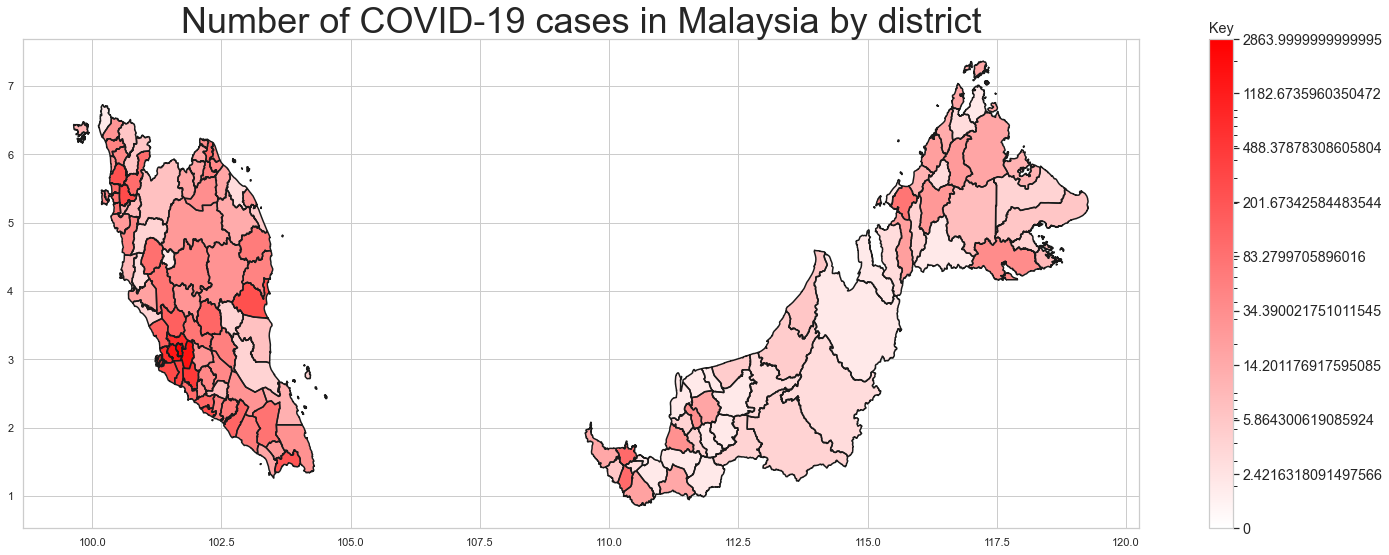

In [155]:
# generate the plot and get the anomalous data (takes around 30-40 seconds)
rs = plot_map_fill(sf, figsize=(25, 9))

In [102]:
# display a list of all the districts that displayed "NA" on the map
district_records.iloc[rs]

,fa,country,state,district,misc1,misc2,misc3,misc4,misc5
84,FA001,MYS,KEDAH,PULAU DAYANG BUNTING,-99999999,0,UNK,UNK,MYS
104,FA001,MYS,KEDAH,PULAU SINGA BESAR,-99999999,0,UNK,UNK,MYS
105,FA001,MYS,KEDAH,PULAU TUBA,-99999999,0,UNK,UNK,MYS
106,FA001,MYS,KEDAH,ALOR SETAR,-99999999,0,UNK,UNK,MYS
123,FA001,MYS,TERENGGANU,PULAU REDANG,-99999999,0,UNK,UNK,MYS
